In [1]:
%load_ext autoreload
%autoreload 2

import hydra
import os
import datetime
from pathlib import Path

# Initialize hydra and move to the root of the repository
try:
    hydra.initialize(version_base=None, config_path="../config/")
    CONFIG = hydra.compose(config_name="main.yaml")
    print('Initializing hydra')
except:
    print('Hydra already initalized!')
else:
    os.chdir('..')
    # Create an output folder in the root of the repository
    OUTPUT_FOLDER = Path('output/{0}'.format(datetime.datetime.now()).replace(' ', '_'))
    Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

Initializing hydra


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from src.utils.colors import flatuicolors
from src.utils.styling import get_standard_colors
from src.weighted_network import WeightedNetwork
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cf
from src.utils.styling import hide_and_move_axis
from src.temporal_network import TemporalNetwork

In [36]:
def map_setup(ax):
    ax.coastlines()
    ax.add_feature(cf.BORDERS, ls=':')
    ax.set_extent([4, 11.5, 44, 53.5])
    #ax.add_feature(cf.LAND, color='k', alpha=0.05)

def plot_community(ax, network, comms=None, reference_network=None):

    if not reference_network:
        reference_network = network
        
    colors = get_standard_colors()
    G = network.G()
    pos = network.position()
    G_ref = reference_network.G()

    if not comms:
        comms = network.communities()
    
    nx.draw_networkx_edges(G, pos, alpha=0.01, ax=ax)
    sc = nx.draw_networkx_nodes(G_ref, pos, node_size=8, node_color='w', alpha=0.25, ax=ax)
    sc.set_edgecolor('k')
    
    for i, comm in enumerate(comms):
        sc = nx.draw_networkx_nodes(G, pos, nodelist=comm, node_size=12, node_color=colors[i], ax=ax)
        sc.set_edgecolor('k')
        sc.set_linewidth(.15)

def load(year0=None, year1=None, edge_filter=None):
    input_path = Path(CONFIG.data.raw)
    nodes_file = input_path / CONFIG.data.filenames.nodes
    edges_file = input_path / CONFIG.data.filenames.edges
    return WeightedNetwork(nodes_file=nodes_file, edges_file=edges_file, year0=year0, year1=year1, edge_filter=edge_filter)


def load_temporal(edge_filter=None):
    input_path = Path(CONFIG.data.raw)
    nodes_file = input_path / CONFIG.data.filenames.nodes
    edges_file = input_path / CONFIG.data.filenames.edges
    return TemporalNetwork(nodes_file=nodes_file, edges_file=edges_file, edge_filter=edge_filter)

def finalize(filename):
    os.system(f'pdfcrop --margin 5 {filename} {filename}')
    os.system(f'convert -density 400 {filename} {filename}.jpg')

def get_temporal_communities(bins, edge_filter=None):

    # Get list of communities for each time slice
    comm_list = []
    for year0, year1 in bins:
        G = load(year0=year0, year1=year1, edge_filter=edge_filter)
        comm_list.append(G.communities())

    sorted_comm_list = [comm_list[0]]
    
    for i in range(1, len(comm_list)):
        
        old_comm = sorted_comm_list[i-1]
        new_comm = comm_list[i]
        sorted_new_comm = []
    
        for oc in old_comm:
            overlap = [len(oc.intersection(nc)) for nc in new_comm]
            index = np.argmax(overlap)
            sorted_new_comm.append(new_comm[index])
            new_comm = new_comm[:index] + new_comm[index+1:]
    
        for nc in new_comm:
            sorted_new_comm.append(nc)
    
        sorted_comm_list.append(sorted_new_comm)

    return sorted_comm_list

def plot_temporal_evolution_of_governance(network, normalize=True):

    fig, axarr = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(8, 4))
    flatax = axarr.flatten()
    colors = get_standard_colors()
    
    communities = network.communities()
    edges = network.edges()
        
    for i, community in enumerate(communities):
    
        in_edges = edges[edges['from'].isin(community) & edges['to'].isin(community)]
        timeseries = in_edges.groupby('Year').ruling_party_category.value_counts().unstack().fillna(0)
    
        if 'R' not in timeseries.columns:
            timeseries['R'] = 0
        if 'S' not in timeseries.columns:
            timeseries['S'] = 0

        if normalize:
            norm = timeseries.S + timeseries.R
            label = 'Share of links\nin Community'
            filename = 'timeseries_governance_relative.jpg'
        else:
            norm = 1
            label = 'Number of links\nin Community'
            filename = 'timeseries_governance_absolute.jpg'
            
        flatax[i].plot(timeseries.index, timeseries.S / norm , label='Secular', c=colors[i])
        flatax[i].plot(timeseries.index, timeseries.R / norm, label='Religious', c=colors[i], ls='--')
        hide_and_move_axis(flatax[i])
            
    flatax[i].legend()

    for ax in axarr[1, :]:
        ax.set_xlabel('Year')
    
    for ax in axarr[:, 0]:
        ax.set_ylabel(label)
    
    plt.tight_layout()

    plt.savefig(OUTPUT_FOLDER / filename, dpi=400)

In [26]:
EDGE_FILTER = 'S238'

G = load(edge_filter=EDGE_FILTER)
G_temp = load_temporal(edge_filter=EDGE_FILTER)

CRS = ccrs.LambertAzimuthalEqualArea(
    central_latitude=CONFIG.grid.central_latitidue, 
    central_longitude=CONFIG.grid.central_longitude, 
    false_easting=CONFIG.grid.false_easting, 
    false_northing=CONFIG.grid.false_northing
)

No time frame specified. Using full data.
Constructing networks...
Computing hamming distance...


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `output/2024-02-16_11:15:09.971445/communities.pdf'.


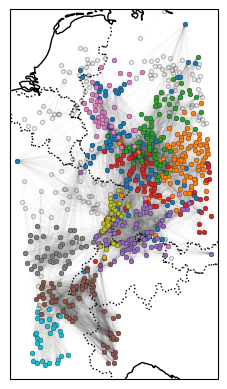

In [37]:
ax = plt.axes(projection=CRS)
map_setup(ax)

plot_community(ax, G)
filename = OUTPUT_FOLDER / 'communities.pdf'
plt.savefig(filename)

finalize(filename)

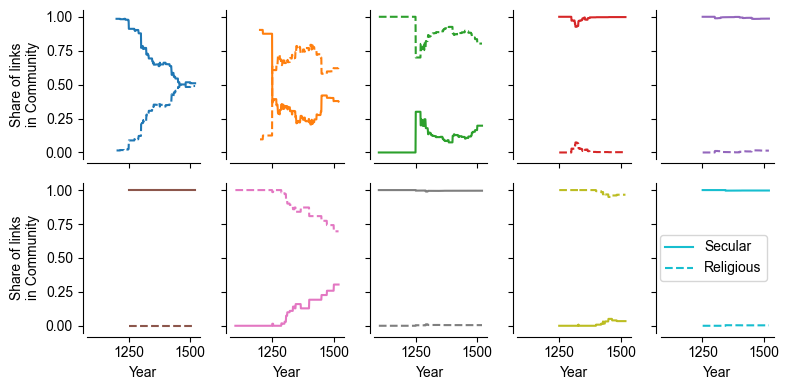

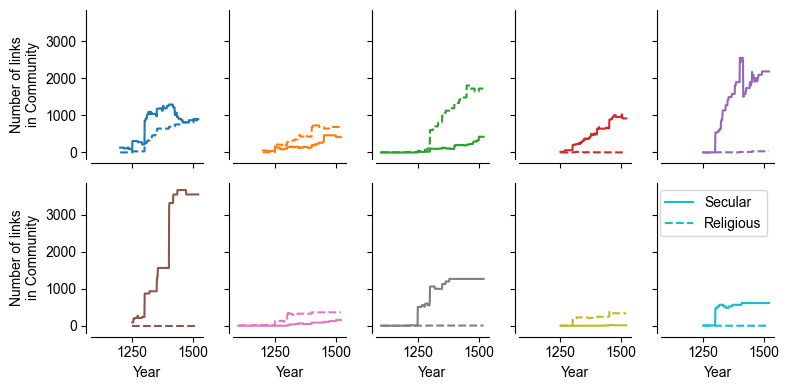

In [32]:
plot_temporal_evolution_of_governance(G)
plot_temporal_evolution_of_governance(G, normalize=False)

In [43]:
# Work in progress. 
# TODO: Don't hardcode number of axes and extent.
def plot_temporal_communities(bins, network, temporal_communites, nrows=2, ncols=3, filename='temporal_communities.pdf', axis_order=None, edge_filter=None):

    f, axarr = plt.subplots(nrows, ncols, subplot_kw={'projection': CRS}, figsize=(2.5 * ncols * 1.25, 4 * nrows * 1.25))
    plt.subplots_adjust(wspace=.05, hspace=.1)
    
    axarr = axarr.flatten()
    if axis_order is not None:
        axarr = axarr.flatten()[axis_order]
    
    for bin, ax, comm in zip(bins, axarr, temporal_communites):
        ax.set_title(f'{bin[0]} to {bin[1]}')
        sliced_network = load(year0=bin[0], year1=bin[1], edge_filter=edge_filter)
        map_setup(ax)
        plot_community(ax, sliced_network, comm, reference_network=network)
    
    filename = OUTPUT_FOLDER / filename
    plt.savefig(filename)
    finalize(filename)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `output/2024-02-16_11:15:09.971445/temporal_networks_hamming.pdf'.


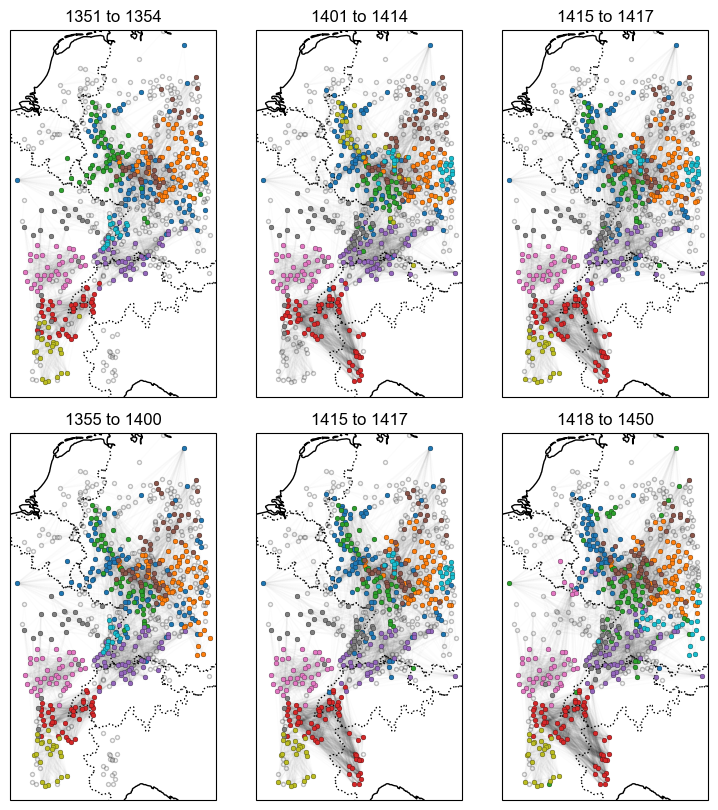

In [45]:
BINS = [(1351, 1354), (1355, 1400), (1401, 1414), (1415, 1417), (1415, 1417), (1418, 1450)]
comm_list = get_temporal_communities(BINS, edge_filter=EDGE_FILTER)
plot_temporal_communities(BINS, G, comm_list, filename='temporal_networks_hamming.pdf', axis_order=[0, 3, 1, 2, 4, 5], edge_filter=EDGE_FILTER) 

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `output/2024-02-16_11:15:09.971445/temporal_networks.pdf'.


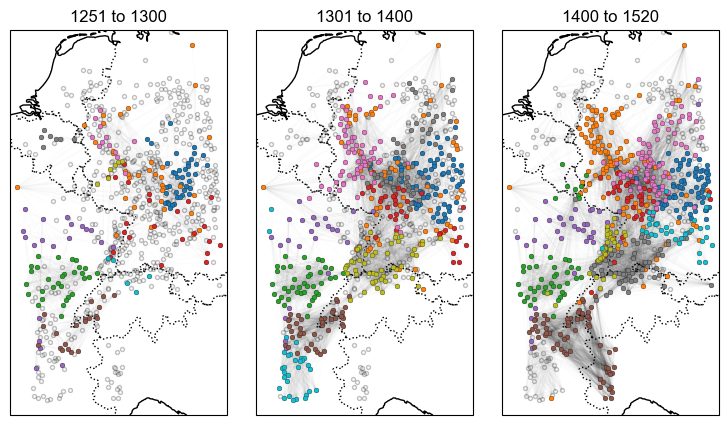

In [44]:
BINS = [(1251, 1300), (1301, 1400), (1400, 1520)]
comm_list = get_temporal_communities(BINS, edge_filter=EDGE_FILTER)
plot_temporal_communities(BINS, G, comm_list, nrows=1, ncols=3, filename='temporal_networks.pdf', edge_filter=EDGE_FILTER)

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(5, 3.5), sharex=True)

yrs = G_temp.years()
H = G_temp.hamming_distance()
K = G_temp.average_degree_sequence()

mask = yrs >= 1200
yrs = yrs[mask]
H = H[mask]
K = K[mask]

mask1 = ((yrs - 1) % 50) != 0
mask2 = H > 400
print(yrs[mask1 & mask2])

axarr[0].plot(yrs, K, c=flatuicolors.wetasphalt)
axarr[1].plot(yrs[mask1], H[mask1], c=flatuicolors.wetasphalt)

for ax in axarr:
    hide_and_move_axis(ax)

for yr in yrs[mask1 & mask2]:
    for ax in axarr:
        ax.axvline(yr, zorder=0, c=flatuicolors.pomegranate, lw=4, alpha=0.3)

        
axarr[1].axhline(400, ls=':', c='k')
axarr[1].set_xlabel('Year')
axarr[0].set_ylabel('Average Degree')
axarr[1].set_ylabel('Hamming Distance')
plt.tight_layout()
plt.savefig(OUTPUT_FOLDER / 'temporal_evolution.png', dpi=400)